#  Table of Contents
1. [Project Overview](#project-overview)
2. [Data Loading](#data-loading)
3. [EDA](#eda)
4. [Preprocessing](#preprocessing)
5. [Model Training](#model-training)
6. [Evaluation](#evaluation)
7. [SHAP Interpretation](#shap-interpretation)
8. [Save & Load Model](#save--load-model)


## Project Overview <a name="project-overview"></a>
# Customer Churn Prediction

This project aims to build a machine learning model to **predict whether a customer will churn** (i.e., leave the company) based on historical data.  
We use a dataset containing customer demographics, account information, and service usage.  

Steps covered:
- Data exploration and preprocessing
- Feature scaling and encoding
- Model training using Random Forest
- Evaluation with accuracy, precision, recall, and F1-score
- Model explanation using SHAP values


## Data Loading <a name="data-loading"></a>


In [2]:
import pandas as pd

df = pd.read_csv('customer_churn.csv')
df.head()


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


## EDA <a name="eda"></a>

In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df['Churn'].value_counts())  # Check class balance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB
None
         CustomerID           Age        Tenure  Usage Frequency  \
count  64374.000000  64374.000000  64374.000000     64374.000000   
mean   32187.500000     41.970982     31.9

## Preprocessing <a name="preprocessing"></a>

In [4]:
df.drop('CustomerID', axis=1, inplace=True)


In [5]:
numerical_cols = df.select_dtypes(include='int64').columns.tolist()
numerical_cols.remove('Churn')  # Target column

categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
Categorical Columns: ['Gender', 'Subscription Type', 'Contract Length']


Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Define Preprocessing Pipelines

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numerical pipeline
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])


Build the Full Pipeline with Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])


## Model Training <a name="model-training"></a>

In [9]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender',
                                                   'Subscription Type',
                                                   'Contract Length'])])),
                ('model', RandomForestClassifier(random_state=42))])

## Evaluation <a name="evaluation"></a>

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[6773    3]
 [  16 6083]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6776
           1       1.00      1.00      1.00      6099

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875



## SHAP Interpretation <a name="shap-interpretation"></a>

 98%|===================| 976/1000 [00:31<00:00]       

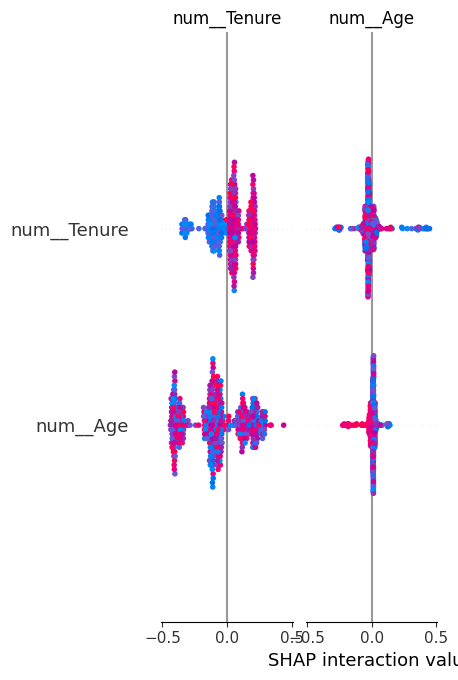

In [15]:
import shap
import numpy as np

# Sample data
sample_idx = np.random.choice(X_test.shape[0], size=500, replace=False)
X_sample = X_test.iloc[sample_idx]

# Apply preprocessing
X_transformed = pipeline.named_steps['preprocessing'].transform(X_sample)

# Get feature names after one-hot encoding
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Create DataFrame for SHAP plotting
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Use only the model (RandomForest)
explainer = shap.Explainer(pipeline.named_steps['model'], X_transformed_df)

# SHAP values
shap_values = explainer(X_transformed_df, check_additivity=False)

# Plot
shap.summary_plot(shap_values, X_transformed_df)


## Save & Load Model <a name="save--load-model"></a>

In [20]:
import joblib

joblib.dump(model, 'churn_model_compressed.joblib', compress=3)


['churn_model_compressed.joblib']